### Classification of loan defaults and stock market direction in terms of daily percentage change
This two part project addresses :
   1. Default prediction on loans
   2. Daily stock market percentage change  
   
The datasets are retreived from the ISLR package in R.  

Loan Default prediction:
- The deualt variable and the student variable are factorized.
- Balance, Income, and Student are used to predict if a loan would default or not.
- A logistic regression model is built and AUC ROC score is reported.  

Market Percentage Change Prediction:  
- Lagged percentage channge values as well as current percentage change values along with trading volume are used to predict the direction of the market.
- The year variable is one hot encoded.
- 4 Models are built and their confusion matrix metrics are reported:
    1. Logistic Regression
    2. Linear Discriminant Analysis
    3. Quadratic Discriminant Analysis
    4. K-Nearest Neighbors    
    
Amongst all models Logistic Regression and Linear Discriminant Analysis provide the best performance in terms of True Positive Rate/Recall. This could be useful for going long on futures. However, the Quadratic Dscriminant model lags on Recall, but makes up for this lag by the increase in True Negative Rate/Specificity which can be useful for shorting futures.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
plt.style.use('seaborn-dark')

import sklearn.linear_model as skl_lm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import preprocessing 
from sklearn import neighbors
import joblib

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
default = pd.read_csv('..\Datasets\Default.csv', index_col=0)

In [3]:
default['default_factor'] = default['default'].factorize()[0]
default['student_factor'] = default['student'].factorize()[0]

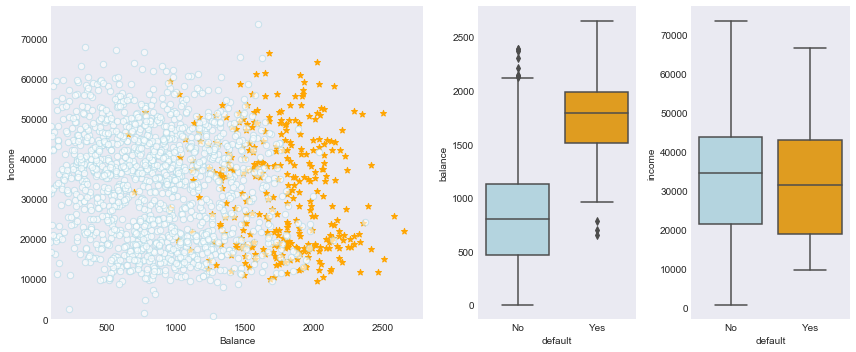

In [4]:
fig = plt.figure(figsize=(12,5))
# https://www.python-course.eu/matplotlib_gridspec.php
gs = fig.add_gridspec(1,4)
ax1 = fig.add_subplot(gs[0, :-2])
ax2 = fig.add_subplot(gs[0, -2])
ax3 = fig.add_subplot(gs[0, -1])

frac_no = default[default['default_factor']==0].sample(frac=0.15)
frac_yes = default[default['default_factor']==1]
sample = frac_no.append(frac_yes)

ax1.scatter(sample[sample['default_factor']==1]['balance'], sample[sample['default_factor']==1]['income'], s=40, c='orange', marker='*', linewidths=1)
ax1.scatter(sample[sample['default_factor']==0]['balance'], sample[sample['default_factor']==0]['income'], s=40, edgecolors='lightblue', marker='o', linewidths=1, facecolors='white', alpha=0.6)

ax1.set_ylim(ymin=0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=100)
ax1.set_xlabel('Balance')

c_palette = {'No':'lightblue', 'Yes':'orange'}
sns.boxplot('default', 'balance', data=default, orient='v', ax=ax2, palette=c_palette)
sns.boxplot('default', 'income', data=default, orient='v', ax=ax3, palette=c_palette)
gs.tight_layout(plt.gcf())

In [5]:
#train test split
x = default[['balance', 'income', 'student_factor']]
y = default[['default_factor']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

In [6]:
# train and save the model
logit = skl_lm.LogisticRegression(solver='newton-cg')
logit.fit(x_train, y_train)

C:\Users\alley\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\alley\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\alley\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\alley\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [7]:
# save the model
joblib.dump(logit, 'logistic_classifier.pkl')

['logistic_classifier.pkl']

In [7]:
# load the model
logit = joblib.load('logistic_classifier.pkl')

In [8]:
logit_predict = logit.predict(x_test)
logit_predict_proba = logit.predict_proba(x_test)
print('Logistic Classifier Probability Estimates')
pd.DataFrame(logit_predict_proba, columns=logit.classes_).head()

Logistic Classifier Probability Estimates


,0,1
0,0.999496,0.000504
1,0.999972,0.000028
2,0.995291,0.004709
3,0.999970,0.000030
4,0.998654,0.001346


In [8]:
print('ROC AUC Score works with the probability score of the class with the greater label. In this case label 1. Label: ', logit.classes_)
print('ROC AUC Score: ', roc_auc_score(y_test, logit_predict_proba[:,1])*100)

ROC AUC Score works with the probability score of the class with the greater label. In this case label 1. Label:  [0 1]
ROC AUC Score:  96.03483341942149


### Classification on Market Data
The goal below is to predict the direction of the market on any given day of the year. The lags show the shifted percentage changes. Lag 1 shows a shifted series of percentage changes by one shift and so on with today give the series without any lag. Volume here is a standardized variable to make sure it stays in a comparable magnitude to the market percentage change lags.

In [9]:
smarket = pd.read_csv('../Datasets/smarket.csv', index_col=0)

In [10]:
smarket.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1250 entries, 1 to 1250
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       1250 non-null   int64  
 1   Lag1       1250 non-null   float64
 2   Lag2       1250 non-null   float64
 3   Lag3       1250 non-null   float64
 4   Lag4       1250 non-null   float64
 5   Lag5       1250 non-null   float64
 6   Volume     1250 non-null   float64
 7   Today      1250 non-null   float64
 8   Direction  1250 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 97.7+ KB


In [11]:
smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
4,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
5,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [12]:
smarket['Year'] = smarket['Year'].astype('category')
smarket['Direction'] = smarket['Direction'].astype('category')

In [13]:
smarket.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1250 entries, 1 to 1250
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Year       1250 non-null   category
 1   Lag1       1250 non-null   float64 
 2   Lag2       1250 non-null   float64 
 3   Lag3       1250 non-null   float64 
 4   Lag4       1250 non-null   float64 
 5   Lag5       1250 non-null   float64 
 6   Volume     1250 non-null   float64 
 7   Today      1250 non-null   float64 
 8   Direction  1250 non-null   category
dtypes: category(2), float64(7)
memory usage: 80.9 KB


In [14]:
#binary label which can be factorized
smarket['Direction'].unique()

[Up, Down]
Categories (2, object): [Up, Down]

In [15]:
def binarize(value):
    if value=='Up':
        value=1
    elif value=='Down':
        value=0
    return value

smarket['Direction'] = smarket['Direction'].apply(binarize)

In [16]:
x = smarket.iloc[:,:-1]
y = smarket.iloc[:,-1]

In [17]:
#use a pandas dataframe to enter into one hot encoder
year = x[['Year']]
year.head()

,Year
1,2001
2,2001
3,2001
4,2001
5,2001


In [18]:
encoder = OneHotEncoder()
year = encoder.fit_transform(year.values).toarray()

In [19]:
encoder.categories_

[array([2001, 2002, 2003, 2004, 2005], dtype=int64)]

In [20]:
x = pd.concat([pd.DataFrame(year, columns=encoder.categories_[0], index=x.index), x.iloc[:,1:]], axis=1)

In [21]:
x.head()

,2001,2002,2003,2004,2005,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
1,1.0,0.0,0.0,0.0,0.0,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959
2,1.0,0.0,0.0,0.0,0.0,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032
3,1.0,0.0,0.0,0.0,0.0,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623
4,1.0,0.0,0.0,0.0,0.0,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614
5,1.0,0.0,0.0,0.0,0.0,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213


### Train Test Split

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x.iloc[:,:11], y, test_size=0.2, random_state=123)

### Direction:
- 1 -> UP
- 0 -> DOWN

### Classification Models:
- Logistic Regression
- Linear DIscriminant Analysis
- Quadratic Discriminant Analysis
- KNN

### Logistic Regression

In [23]:
logit = skl_lm.LogisticRegression()
logit.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

- Classify a probaility of > 0.5 as 1 to denote UP direction.
- Classify a probability of <= 0.5 to denote a DOWN direction.

In [24]:
def classify(x):
    if x>0.5:
        x=1
    elif x<=0.5:
        x=0
    return x

In [25]:
logit_pred = pd.Series(logit.predict_proba(x_test)[:,1]).apply(classify)

In [26]:
tn, fp, fn, tp = confusion_matrix(y_test, logit_pred).ravel()

In [27]:
pd.crosstab(y_test.values,
           logit_pred,
           rownames=['Actual'],
           colnames=['Predicted'],
           margins=False)

Predicted,0,1
Actual,,
0,37,84
1,34,95


In [30]:
print("Logistic Regression Results:\n")
print('Accuracy: ', round((tp+tn)/(tp+tn+fp+fn),3))
print('Misclassification Rate: ', round((fp+fn)/(tp+tn+fp+fn),3))
print('True Positive Rate/Recall: ', round((tp)/(tp+fn),3))
print('True Negative Rate/Specificity: ', round((tn)/(tn+fp),3))

Logistic Regression Results:

Accuracy:  0.528
Misclassification Rate:  0.472
True Positive Rate/Recall:  0.736
True Negative Rate/Specificity:  0.306


In [31]:
print(classification_report(y_test.values, logit_pred, digits=3))

              precision    recall  f1-score   support

           0      0.521     0.306     0.385       121
           1      0.531     0.736     0.617       129

    accuracy                          0.528       250
   macro avg      0.526     0.521     0.501       250
weighted avg      0.526     0.528     0.505       250



### Linear Discriminant Analysis

In [32]:
lda_model = LinearDiscriminantAnalysis() 
lda_model.fit(x_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [33]:
lda_pred = pd.Series(lda_model.predict_proba(x_test)[:,1]).apply(classify)

In [34]:
pd.crosstab(y_test.values,
           lda_pred,
           colnames=['Predicted'],
           rownames=['Actual'],
           margins=False)

Predicted,0,1
Actual,,
0,40,81
1,34,95


In [35]:
tn, fp, fn, tp = confusion_matrix(y_test, lda_pred).ravel()

In [37]:
print("Linear Discriminant Analysis Results:\n")
print('Accuracy: ', round((tp+tn)/(tp+tn+fp+fn),3))
print('Misclassification Rate: ', round((fp+fn)/(tp+tn+fp+fn),3))
print('True Positive Rate/Recall: ', round((tp)/(tp+fn),3))
print('True Negative Rate/Specificity: ', round((tn)/(tn+fp),3))

Linear Discriminant Analysis Results:

Accuracy:  0.54
Misclassification Rate:  0.46
True Positive Rate/Recall:  0.736
True Negative Rate/Specificity:  0.331


In [38]:
print(classification_report(y_test.values, lda_pred, digits=3))

              precision    recall  f1-score   support

           0      0.541     0.331     0.410       121
           1      0.540     0.736     0.623       129

    accuracy                          0.540       250
   macro avg      0.540     0.534     0.517       250
weighted avg      0.540     0.540     0.520       250



### Quadratic Discriminant Analysis

In [39]:
qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(x_train, y_train)

C:\Users\alley\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [40]:
qda_pred = pd.Series(qda_model.predict_proba(x_test)[:,1]).apply(classify)

In [41]:
pd.crosstab(y_test.values,
            qda_pred,
           colnames=['Predicted'],
           rownames=['Actual'],
           margins=False)

Predicted,0,1
Actual,,
0,56,65
1,48,81


In [42]:
tn, fp, fn, tp = confusion_matrix(y_test, qda_pred).ravel()

In [43]:
print("Quadratic Discriminant Analysis Results:\n")
print('Accuracy: ', round((tp+tn)/(tp+tn+fp+fn),3))
print('Misclassification Rate: ', round((fp+fn)/(tp+tn+fp+fn),3))
print('True Positive Rate/Recall: ', round((tp)/(tp+fn),3))
print('True Negative Rate/Specificity: ', round((tn)/(tn+fp),3))

Quadratic Discriminant Analysis Results:

Accuracy:  0.548
Misclassification Rate:  0.452
True Positive Rate/Recall:  0.628
True Negative Rate/Specificity:  0.463


In [44]:
print(classification_report(y_test.values, qda_pred, digits=3))

              precision    recall  f1-score   support

           0      0.538     0.463     0.498       121
           1      0.555     0.628     0.589       129

    accuracy                          0.548       250
   macro avg      0.547     0.545     0.543       250
weighted avg      0.547     0.548     0.545       250



### K-nearest neighbor classifier

In [45]:
knn_model = neighbors.KNeighborsClassifier()
knn_model.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [47]:
knn_pred = pd.Series(knn_model.predict_proba(x_test)[:,1]).apply(classify)

In [52]:
pd.crosstab(y_test.values,
           knn_pred,
           colnames=['Predicted'],
           rownames=['Actual'],
           margins=False)

Predicted,0,1
Actual,,
0,53,68
1,64,65


In [53]:
tn, fp, fn, tp = confusion_matrix(y_test, knn_pred).ravel()

In [54]:
print("k-nearest neighbor Results:\n")
print('Accuracy: ', round((tp+tn)/(tp+tn+fp+fn),3))
print('Misclassification Rate: ', round((fp+fn)/(tp+tn+fp+fn),3))
print('True Positive Rate/Recall: ', round((tp)/(tp+fn),3))
print('True Negative Rate/Specificity: ', round((tn)/(tn+fp),3))

k-nearest neighbor Results:

Accuracy:  0.472
Misclassification Rate:  0.528
True Positive Rate/Recall:  0.504
True Negative Rate/Specificity:  0.438


In [55]:
print(classification_report(y_test.values, knn_pred, digits=3))

              precision    recall  f1-score   support

           0      0.453     0.438     0.445       121
           1      0.489     0.504     0.496       129

    accuracy                          0.472       250
   macro avg      0.471     0.471     0.471       250
weighted avg      0.471     0.472     0.472       250

